In [1]:
%load_ext autoreload
%autoreload 2

# Point sources in heterogeneous media

## Setup the problem

In [3]:
from jwave.geometry import Domain, Medium, TimeAxis, Sources
from jax import numpy as jnp
from matplotlib import pyplot as plt

In [4]:
# Domain
N = (512, 512)
domain = Domain( N, (.5,.5))

# Physical properties
sound_speed = jnp.ones(N) 
sound_speed = sound_speed.at[100:200,200:300].set(2.)
sound_speed = sound_speed.at[150:250,250:450].set(1.5)
sound_speed = sound_speed.at[350:400,150:350].set(1.3)

medium = Medium(
    domain=domain,
    sound_speed = sound_speed,
    density = jnp.ones(N),
    attenuation = 0,
    pml_size = 20.
)

time_axis = TimeAxis.from_medium(medium, cfl=0.1, t_end=200.)

In [5]:
# Defining source points
from jwave.signal_processing import apply_ramp

source_freq = 0.1 
source_mag = 5

def gaussian_window(signal, time, mu, sigma):
    return signal*jnp.exp(
        -(t-mu)**2/sigma**2
    )

t = jnp.arange(0, time_axis.t_end, time_axis.dt)
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s1 = gaussian_window(
    apply_ramp(s1, time_axis.dt, source_freq),
    t,
    50,
    10
)
s2 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s2 = gaussian_window(
    apply_ramp(s2, time_axis.dt, source_freq),
    t,
    80,
    15
)

source_signals = jnp.stack([s1,s2])
source_positions = ([150, 450], [64, 340])

sources = Sources(positions=source_positions, signals=source_signals)



Let's look at the problem setup


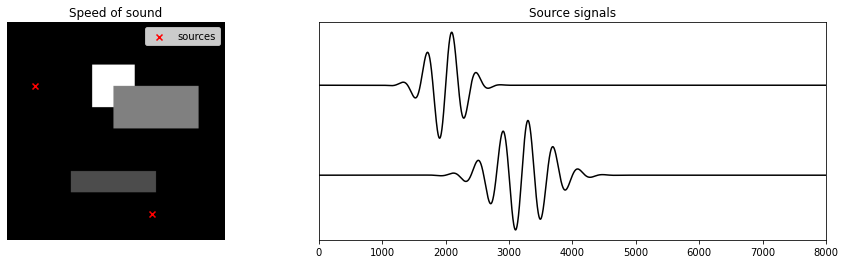

In [10]:
# Show simulation setup
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,4), gridspec_kw={'width_ratios': [1, 2]})

ax[0].imshow(medium.sound_speed, cmap="gray")
ax[0].scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
ax[0].legend()
ax[0].set_title("Speed of sound")
ax[0].axis("off")

ax[1].plot(s1+4, label="Source 1", c='k')
ax[1].plot(s2-4, label="Source 2", c='k')
ax[1].set_title("Source signals")
ax[1].set_xlim([0,8000])
ax[1].get_yaxis().set_visible(False)

## Run the simulation

In [11]:
from jwave.acoustics import ongrid_wave_propagation
from jax import jit

# Setup simiulation
output_taxis = TimeAxis(dt=time_axis.t_end, t_end=time_axis.t_end)
params, solver = ongrid_wave_propagation(
    medium=medium,
    time_array=time_axis,
    sources=sources,
    output_t_axis = output_taxis
)
solver = jit(solver)

In [12]:
fields = solver(params)
u = fields[0]
p = jnp.sum(fields[1],-1)*(medium.sound_speed**2)

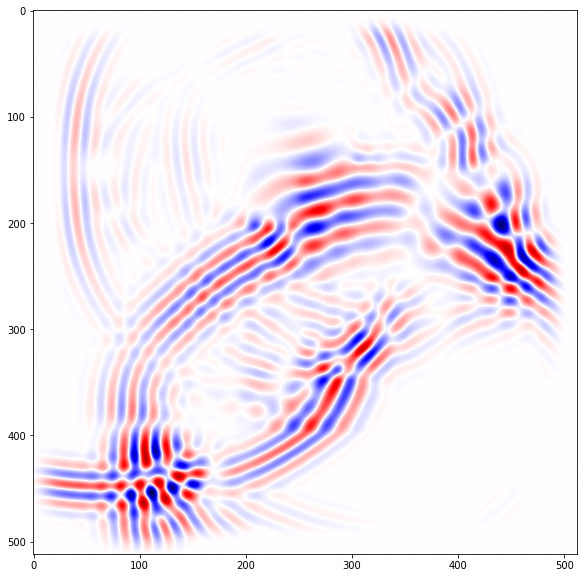

In [13]:
plt.figure(figsize=(10,10))
maxval = jnp.amax(jnp.abs(p[-1]))
plt.imshow(p[-1], cmap="seismic", vmin=-maxval, vmax=maxval)

## Testing pml

In [14]:
from jwave.acoustics import td_pml_on_grid

pml = td_pml_on_grid(medium, dt=0.1)

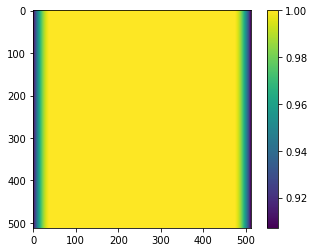

In [15]:
plt.imshow(pml[...,1])
plt.colorbar()